# 0. Load Files

In [46]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [47]:
df = pd.read_parquet('C://Users/Isi/anaconda3/envs/FireBrigade/MAY24_BDS_INT_Fire_Brigade/data/df_cleaned_for_classification_models.parquet')
df.head() 

,IncidentGroup_Fire,IncidentGroup_Special Service,AggregatedPropertyCategory_Outdoor,AggregatedPropertyCategory_Residential,AggregatedPropertyCategory_Vehicle,CellEastingNorthing2500_502500-175000,CellEastingNorthing2500_502500-177500,CellEastingNorthing2500_502500-180000,CellEastingNorthing2500_502500-182500,CellEastingNorthing2500_502500-187500,CellEastingNorthing2500_502500-190000,CellEastingNorthing2500_502500-192500,CellEastingNorthing2500_505000-172500,CellEastingNorthing2500_505000-175000,CellEastingNorthing2500_505000-177500,CellEastingNorthing2500_505000-180000,CellEastingNorthing2500_505000-182500,CellEastingNorthing2500_505000-185000,CellEastingNorthing2500_505000-187500,CellEastingNorthing2500_505000-190000,CellEastingNorthing2500_507500-170000,CellEastingNorthing2500_507500-172500,CellEastingNorthing2500_507500-175000,CellEastingNorthing2500_507500-177500,CellEastingNorthing2500_507500-180000,CellEastingNorthing2500_507500-182500,CellEastingNorthing2500_507500-185000,CellEastingNorthing2500_507500-187500,CellEastingNorthing2500_507500-190000,CellEastingNorthing2500_510000-167500,CellEastingNorthing2500_510000-170000,CellEastingNorthing2500_510000-172500,CellEastingNorthing2500_510000-175000,CellEastingNorthing2500_510000-177500,CellEastingNorthing2500_510000-180000,CellEastingNorthing2500_510000-182500,CellEastingNorthing2500_510000-185000,CellEastingNorthing2500_510000-187500,CellEastingNorthing2500_510000-190000,CellEastingNorthing2500_512500-167500,CellEastingNorthing2500_512500-170000,CellEastingNorthing2500_512500-172500,CellEastingNorthing2500_512500-175000,CellEastingNorthing2500_512500-177500,CellEastingNorthing2500_512500-180000,CellEastingNorthing2500_512500-182500,CellEastingNorthing2500_512500-185000,CellEastingNorthing2500_512500-187500,CellEastingNorthing2500_512500-190000,CellEastingNorthing2500_512500-192500,CellEastingNorthing2500_515000-157500,CellEastingNorthing2500_515000-160000,CellEastingNorthing2500_515000-162500,CellEastingNorthing2500_515000-165000,CellEastingNorthing2500_515000-167500,CellEastingNorthing2500_515000-170000,CellEastingNorthing2500_515000-172500,CellEastingNorthing2500_515000-175000,CellEastingNorthing2500_515000-177500,CellEastingNorthing2500_515000-180000,CellEastingNorthing2500_515000-182500,CellEastingNorthing2500_515000-185000,CellEastingNorthing2500_515000-187500,CellEastingNorthing2500_515000-190000,CellEastingNorthing2500_515000-192500,CellEastingNorthing2500_517500-160000,CellEastingNorthing2500_517500-162500,CellEastingNorthing2500_517500-165000,CellEastingNorthing2500_517500-167500,CellEastingNorthing2500_517500-170000,CellEastingNorthing2500_517500-172500,CellEastingNorthing2500_517500-175000,CellEastingNorthing2500_517500-177500,CellEastingNorthing2500_517500-180000,CellEastingNorthing2500_517500-182500,CellEastingNorthing2500_517500-185000,CellEastingNorthing2500_517500-187500,CellEastingNorthing2500_517500-190000,CellEastingNorthing2500_517500-192500,CellEastingNorthing2500_517500-195000,CellEastingNorthing2500_520000-162500,CellEastingNorthing2500_520000-165000,CellEastingNorthing2500_520000-167500,CellEastingNorthing2500_520000-170000,CellEastingNorthing2500_520000-172500,CellEastingNorthing2500_520000-175000,CellEastingNorthing2500_520000-177500,CellEastingNorthing2500_520000-180000,CellEastingNorthing2500_520000-182500,CellEastingNorthing2500_520000-185000,CellEastingNorthing2500_520000-187500,CellEastingNorthing2500_520000-190000,CellEastingNorthing2500_520000-192500,CellEastingNorthing2500_520000-195000,CellEastingNorthing2500_522500-160000,CellEastingNorthing2500_522500-162500,CellEastingNorthing2500_522500-165000,CellEastingNorthing2500_522500-167500,CellEastingNorthing2500_522500-170000,CellEastingNorthing2500_522500-172500,CellEastingNorthing2500_522500-175000,CellEastingNorthing2500_522500-177500,CellEastingNorthing2500_522500-180000,CellEastingNorthing2500_522500-182500,CellEastingNorthing2500_522500-185000,CellEastingNorthing2500_522500-187500,Cel

# 1. PCA Transformation & Balancing Data Set

In [48]:
X = df.drop("ResponseTimeBinary", axis = 1)
y = df["ResponseTimeBinary"]

In [50]:
pca = PCA(n_components=0.85)
X = pca.fit_transform(X)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 666)

In [52]:
rUs = RandomUnderSampler(random_state=666)
X_train, y_train = rUs.fit_resample(X_train, y_train)
print('Sample classes undersampled :', dict(pd.Series(y_train).value_counts()))

Sample classes undersampled : {0: 361454, 1: 361454}


# 2. Voting Classifier

## 2.1 Instantiating XGBoost, RF, & LogReg Models

In [53]:
xgboost = xgb.XGBClassifier(random_state=666, use_label_encoder=False, eval_metric='logloss', n_estimators=200, max_depth=5, subsample=0.9, learning_rate=0.1)
rf = RandomForestClassifier(random_state=666, criterion='gini', max_depth=10, n_estimators=200)
logreg = LogisticRegression(C=5, penalty='l2', solver='lbfgs', max_iter=10000)

## 2.2 Instantiating Voting Classifier (Soft)

In [54]:
vclf = VotingClassifier(estimators=[('XGboost', xgboost), ('RF', rf), ('LogReg', logreg)], voting='soft')

In [58]:
# Fit the model
vclf.fit(X_train, y_train)

# Print best parameters and best score
print(f"Best Parameters: {vclf_grid.best_params_}")
print(f"Best Score: {vclf_grid.best_score_}")

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

## 2.6 Cross Validation via  GridSearchCV

In [20]:
# Save the best model
#joblib.dump(vclf.best_estimators, 'vclf_hard_grid.pkl')

# To load the model later
#vclf = joblib.load('vclf_hard_grid.pkl')

In [45]:
y_pred_train_vclf_hard = vclf_grid.predict(X_train)
y_pred_test_vclf_hard = vclf_grid.predict(X_test)

## 2.7 Evaluation

Training Dataset Evaluation:
Accuracy: 0.6800
Precision: 0.6694
Recall: 0.7111
F1 Score: 0.6896
ROC AUC Score: 0.6800

Confusion Matrix:
[[234518 126936]
 [104418 257036]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67    361454
           1       0.67      0.71      0.69    361454

    accuracy                           0.68    722908
   macro avg       0.68      0.68      0.68    722908
weighted avg       0.68      0.68      0.68    722908



Test Dataset Evaluation:
Accuracy: 0.6885
Precision: 0.8270
Recall: 0.7071
F1 Score: 0.7624
ROC AUC Score: 0.6755

Confusion Matrix:
[[ 58097  32146]
 [ 63640 153658]]

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.64      0.55     90243
           1       0.83      0.71      0.76    217298

    accuracy                           0.69    307541
   macro avg       0.65      0.68      0.66    307541
weighted av

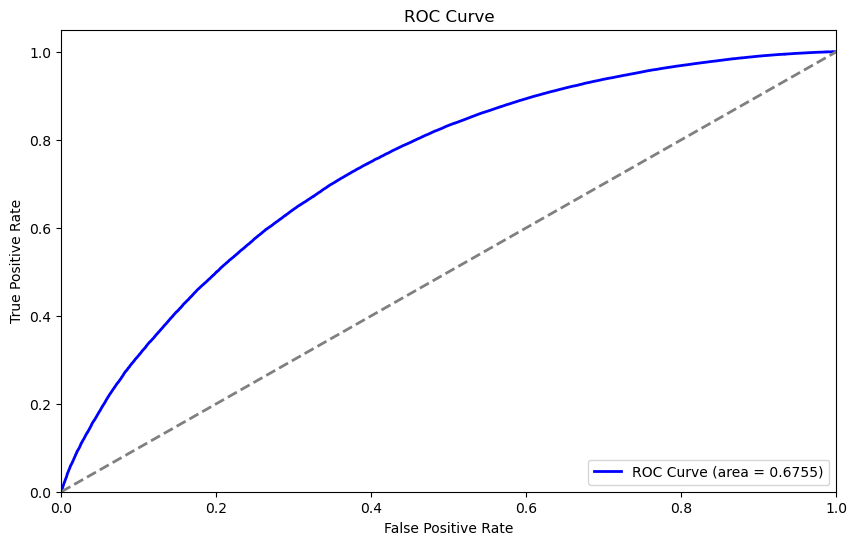

In [36]:
#soft voting

y_pred_train = vclf.predict(X_train)
y_pred_test = vclf.predict(X_test)

def evaluate_model(y_true, y_pred, dataset_type="Test"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    
    print(f"{dataset_type} Dataset Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)
    print("\n" + "="*60 + "\n")
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate on training data
evaluate_model(y_train, y_pred_train, dataset_type="Training")

# Evaluate on test data
evaluate_model(y_test, y_pred_test, dataset_type="Test")

# Plot ROC Curve for test data
fpr, tpr, _ = roc_curve(y_test, vclf.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = %0.4f)' % roc_auc_score(y_test, y_pred_test))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()